In [587]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import  Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

import yfinance as yf


USer defined functions

In [588]:
def call_rmsle(y_true, y_pred):
    # Ensure predictions and true values are positive by adding 1
    y_true = tf.math.maximum(y_true, 0)
    y_pred = tf.math.maximum(y_pred, 0)

    # Compute the logarithm of the true and predicted values
    log_true = tf.math.log1p(y_true)
    log_pred = tf.math.log1p(y_pred)

    # Compute the squared difference
    squared_diff = tf.math.square(log_true - log_pred)

    # Compute the mean of the squared differences
    mean_squared_diff = tf.math.reduce_mean(squared_diff)

    # Return the square root of the mean squared differences
    return tf.math.sqrt(mean_squared_diff)

def remove_leading_zeros(df):
    # Find the index of the first non-zero sales value
    first_non_zero_index = df['sales'].ne(0).idxmax()

    # Filter the DataFrame to remove leading zeros
    return df.loc[first_non_zero_index:]

In [589]:
#df_train_all    = pd.read_csv('data/SPX.csv')

start_date = "2021-01-03"
end_date   = "2024-11-01"

data = yf.download("^NSEI", start=start_date, end=end_date)
data.columns = data.columns.get_level_values(0) # from multi index to single index

data = data.reset_index()

data.head()


[*********************100%***********************]  1 of 1 completed


Price,Date,Adj Close,Close,High,Low,Open,Volume
0,2021-01-04 00:00:00+00:00,14132.900391,14132.900391,14147.950195,13953.750000,14104.349609,495000
1,2021-01-05 00:00:00+00:00,14199.500000,14199.500000,14215.599609,14048.150391,14075.150391,492500
2,2021-01-06 00:00:00+00:00,14146.250000,14146.250000,14244.150391,14039.900391,14240.950195,632300
3,2021-01-07 00:00:00+00:00,14137.349609,14137.349609,14256.250000,14123.099609,14253.750000,559200
4,2021-01-08 00:00:00+00:00,14347.250000,14347.250000,14367.299805,14221.650391,14258.400391,613500


In [590]:

data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
data['Date'] = pd.to_datetime(data['Date']).dt.date
#data.set_index('Date', inplace=True)

df_train_all = data.copy()

df_train_all.head()


Price,Date,Adj Close,Close,High,Low,Open,Volume
0,2021-01-04,14132.900391,14132.900391,14147.950195,13953.750000,14104.349609,495000
1,2021-01-05,14199.500000,14199.500000,14215.599609,14048.150391,14075.150391,492500
2,2021-01-06,14146.250000,14146.250000,14244.150391,14039.900391,14240.950195,632300
3,2021-01-07,14137.349609,14137.349609,14256.250000,14123.099609,14253.750000,559200
4,2021-01-08,14347.250000,14347.250000,14367.299805,14221.650391,14258.400391,613500


Data preprocessing

In [591]:
#df_train_all['10DMA'] =  df_train_all['Adj Close'].rolling(window=10).mean()
#df_train_all['30DMA'] =  df_train_all['Adj Close'].rolling(window=30).mean()
#df_train_all['100DMA'] =  df_train_all['Adj Close'].rolling(window=100).mean()

#df_train_all.dropna(subset=['100DMA'], inplace=True)

In [592]:
import calendar
from datetime import datetime, timedelta
def is_last_thursday(date):
    year = date.year
    month = date.month
    
    last_day = calendar.monthrange(year, month)[1]
    last_date = datetime(year, month, last_day)
    last_day_weekday = last_date.weekday()
    days_since_last_thursday = (last_day_weekday - calendar.THURSDAY) % 7
    last_thursday_date = last_date - timedelta(days=days_since_last_thursday)
    
    return 1 if date.date() == last_thursday_date.date() else 0




In [593]:
df_train_all.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [594]:
df_train_all['Date'] = pd.to_datetime(df_train_all['Date'])

#df_train_all['day'] = df_train_all['Date'].dt.day
#df_train_all['month'] = df_train_all['Date'].dt.month
#df_train_all['year'] = df_train_all['Date'].dt.year

df_train_all['opt_exp'] = df_train_all['Date'].apply(is_last_thursday)
#df_train_all['year'] = df_train_all['year'] - df_train_all['year'].min()

In [595]:
df_train_all['next_close'] = df_train_all['Close'].shift(-1)
df_train_all['pct_change'] = df_train_all['next_close'] - df_train_all['Close']
df_train_all.dropna(subset=['pct_change'], inplace=True)

In [596]:
#df_train_all['price_next'] = df_train_all['Close'].shift(-1)
df_train_all['prev_close'] = df_train_all['Close'].shift(1)

df_train_all['pct_change_in_a_day'] = df_train_all['Close']/df_train_all['Open']  
#df_train_all['opening_gap'] = df_train_all['Open'] - df_train_all['prev_close'] 
#df_train_all['daily_move'] = df_train_all['High'] - df_train_all['Low']
#df_train_all['daily_move']= df_train_all['daily_move'].shift(1) #previous day daily movement
#df_train_all['daily_move_avg'] =  df_train_all['daily_move'].rolling(window=5).mean() #average of last 5 day movement

In [597]:
split_date   = '2024-06-30'

df_train = df_train_all[df_train_all['Date']<=  split_date] #keeping 4 years for training 
df_test  = df_train_all[df_train_all['Date']>  split_date] #keeping last year for testing

In [598]:
#df_train.dropna(subset=['daily_move_avg'], inplace=True)

df_train.columns

Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'opt_exp', 'next_close', 'pct_change', 'prev_close',
       'pct_change_in_a_day'],
      dtype='object', name='Price')

In [599]:
          
df = df_train.copy()
df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################

# Features to be scaled
features_to_scale = ['Close', 'Volume',
                      'pct_change_in_a_day',]

#features_to_scale = ['Open', 'Close','Volume','10DMA','year','day','month','opening_gap','daily_move_avg']
#features_to_scale = ['Open', 'Close','Volume','10DMA','30DMA','100DMA','opening_gap','daily_move_avg']

# Features to be left unscaled (those ending with 'sin' or 'cos')
#features_to_leave = ['opt_exp','month_sin','month_cos','day_sin','day_cos' ]
features_to_leave = ['opt_exp' ]

features = features_to_scale + features_to_leave
#target = 'price_next'
target = 'pct_change'

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.1, shuffle=False)

#X_train = df[features]
#y_train = df[target]
# Initialize scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale only the selected features
X_train_scaled_part = feature_scaler.fit_transform(X_train[features_to_scale])
X_test_scaled_part = feature_scaler.transform(X_test[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_train_scaled = np.hstack((X_train_scaled_part, X_train[features_to_leave].values))
X_test_scaled = np.hstack((X_test_scaled_part, X_test[features_to_leave].values))

# Scale target variable
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))


# Reshape data to fit LSTM input shape (num_samples, timesteps, num_features)
# timesteps = 1  # You need to define this based on your data and model requirements
# X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
# X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))



In [600]:
df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'opt_exp',
       'next_close', 'pct_change', 'prev_close', 'pct_change_in_a_day'],
      dtype='object', name='Price')

In [601]:


# Set 'Date' as the index
#df.set_index('Date ', inplace=True)

# Show the cleaned data
df.head()
data = df.copy()

In [602]:
data.head()

Price,Adj Close,Close,High,Low,Open,Volume,opt_exp,next_close,pct_change,prev_close,pct_change_in_a_day
0,14132.900391,14132.900391,14147.950195,13953.750000,14104.349609,495000,0,14199.500000,66.599609,NaN,1.002024
1,14199.500000,14199.500000,14215.599609,14048.150391,14075.150391,492500,0,14146.250000,-53.250000,14132.900391,1.008835
2,14146.250000,14146.250000,14244.150391,14039.900391,14240.950195,632300,0,14137.349609,-8.900391,14199.500000,0.993350
3,14137.349609,14137.349609,14256.250000,14123.099609,14253.750000,559200,0,14347.250000,209.900391,14146.250000,0.991834
4,14347.250000,14347.250000,14367.299805,14221.650391,14258.400391,613500,0,14484.750000,137.500000,14137.349609,1.006231


In [603]:
data.tail()

Price,Adj Close,Close,High,Low,Open,Volume,opt_exp,next_close,pct_change,prev_close,pct_change_in_a_day
855,23537.849609,23537.849609,23558.099609,23350.000000,23382.300781,239400,0,23721.300781,183.451172,23501.099609,1.006652
856,23721.300781,23721.300781,23754.150391,23562.050781,23577.099609,298100,0,23868.800781,147.500000,23537.849609,1.006116
857,23868.800781,23868.800781,23889.900391,23670.449219,23723.099609,287800,0,24044.500000,175.699219,23721.300781,1.006142
858,24044.500000,24044.500000,24087.449219,23805.400391,23881.550781,515200,1,24010.599609,-33.900391,23868.800781,1.006823
859,24010.599609,24010.599609,24174.000000,23985.800781,24085.900391,354800,0,24141.949219,131.349609,24044.500000,0.996874


In [604]:
data.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'opt_exp',
       'next_close', 'pct_change', 'prev_close', 'pct_change_in_a_day'],
      dtype='object', name='Price')

In [605]:
data_copy= data.copy()

In [606]:
data

Price,Adj Close,Close,High,Low,Open,Volume,opt_exp,next_close,pct_change,prev_close,pct_change_in_a_day
0,14132.900391,14132.900391,14147.950195,13953.750000,14104.349609,495000,0,14199.500000,66.599609,NaN,1.002024
1,14199.500000,14199.500000,14215.599609,14048.150391,14075.150391,492500,0,14146.250000,-53.250000,14132.900391,1.008835
2,14146.250000,14146.250000,14244.150391,14039.900391,14240.950195,632300,0,14137.349609,-8.900391,14199.500000,0.993350
3,14137.349609,14137.349609,14256.250000,14123.099609,14253.750000,559200,0,14347.250000,209.900391,14146.250000,0.991834
4,14347.250000,14347.250000,14367.299805,14221.650391,14258.400391,613500,0,14484.750000,137.500000,14137.349609,1.006231
...,...,...,...,...,...,...,...,...,...,...,...
855,23537.849609,23537.849609,23558.099609,23350.000000,23382.300781,239400,0,23721.300781,183.451172,23501.099609,1.006652
856,23721.300781,23721.300781,23754.150391,23562.050781,23577.099609,298100,0,23868.800781,147.500000,23537.849609,1.006116
857,23868.800781,23868.800781,23889.900391,23670.449219,23723.099609,287800,0,24044.500000,175.699219,23721.300781,1.006142
858,24044.500000,24044.500000,24087.449219,23805.400391,23881.550781,515200,1,24010.599609,-33.900391,23868.800781,1.006823


In [607]:
df_train_all

Price,Date,Adj Close,Close,High,Low,Open,Volume,opt_exp,next_close,pct_change,prev_close,pct_change_in_a_day
0,2021-01-04,14132.900391,14132.900391,14147.950195,13953.750000,14104.349609,495000,0,14199.500000,66.599609,NaN,1.002024
1,2021-01-05,14199.500000,14199.500000,14215.599609,14048.150391,14075.150391,492500,0,14146.250000,-53.250000,14132.900391,1.008835
2,2021-01-06,14146.250000,14146.250000,14244.150391,14039.900391,14240.950195,632300,0,14137.349609,-8.900391,14199.500000,0.993350
3,2021-01-07,14137.349609,14137.349609,14256.250000,14123.099609,14253.750000,559200,0,14347.250000,209.900391,14146.250000,0.991834
4,2021-01-08,14347.250000,14347.250000,14367.299805,14221.650391,14258.400391,613500,0,14484.750000,137.500000,14137.349609,1.006231
...,...,...,...,...,...,...,...,...,...,...,...,...
940,2024-10-24,24399.400391,24399.400391,24480.650391,24341.199219,24412.699219,216700,0,24180.800781,-218.599609,24435.500000,0.999455
941,2024-10-25,24180.800781,24180.800781,24440.250000,24073.900391,24418.050781,372600,0,24339.150391,158.349609,24399.400391,0.990284
942,2024-10-28,24339.150391,24339.150391,24492.599609,24134.900391,24251.099609,278600,0,24466.849609,127.699219,24180.800781,1.003631
943,2024-10-29,24466.849609,24466.849609,24484.500000,24140.849609,24328.849609,332000,0,24340.849609,-126.000000,24339.150391,1.005672


In [608]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Drop the 'Date' column as it's not numeric
df_train_all = df_train_all.drop('Date', axis=1)

# Convert to a NumPy array
data_values = df_train_all.values  # Includes all numeric columns

# Normalize the entire dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_values)

# Create sequences for all columns
def create_sequences_all_columns(data, sequence_length=8):
    sequences = []
    labels = []
    for i in range(sequence_length, len(data)):
        sequences.append(data[i-sequence_length:i, :])  # All columns as input
        labels.append(data[i, 3])  # The 'Close' column as the target (index 3)
    return np.array(sequences), np.array(labels)

# Generate sequences
sequence_length = 128  # Last 60 rows as input
X, y = create_sequences_all_columns(scaled_data, sequence_length)

# Ensure 3D shape for X: (num_samples, sequence_length, num_features)
# y will remain 1D for regression (predicting 'Close')
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split the data into training and testing sets (80-20 split)
train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print shapes for verification
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



X_train shape: (694, 128, 11), y_train shape: (694,)
X_test shape: (123, 128, 11), y_test shape: (123,)


In [609]:
X_train.shape

(694, 128, 11)

In [610]:
X_train.shape[2]

11

In [611]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), dilation_rate=1),
    tf.keras.layers.Dropout(0.1),  # Dropout to prevent overfitting
    
    tf.keras.layers.Conv1D(filters=256, kernel_size=2, activation='relu', dilation_rate=4),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.GlobalAveragePooling1D(),
    
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

# Compile with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

model.summary()


c:\Sadhana\458\Module_7\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)              │ (None, 127, 128)       │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 127, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 123, 256)       │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 123, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_15     │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,761 (397.50 KB)

 Trainable params: 101,761 (397.50 KB)

 Non-trainable params: 0 (0.00 B)

In [612]:
# import tensorflow as tf

# # Build the TCNN model with dilated convolutions
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), dilation_rate=1),  # No dilation for first layer
#     tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', dilation_rate=4),  # Dilated convolution in second layer
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(1)  # Output layer for regression (next day's price)
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
#model.summary()

Epoch 1/100


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.2000 - val_loss: 0.7023
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1448 - val_loss: 0.6276
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1190 - val_loss: 0.5363
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0825 - val_loss: 0.4530
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0561 - val_loss: 0.3840
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0372 - val_loss: 0.3311
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0300 - val_loss: 0.2916
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0256 - val_loss: 0.2643
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0237 - val_loss: 0.2466
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0213 - val_loss: 0.2358
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0203 - val_loss: 0.2290
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0

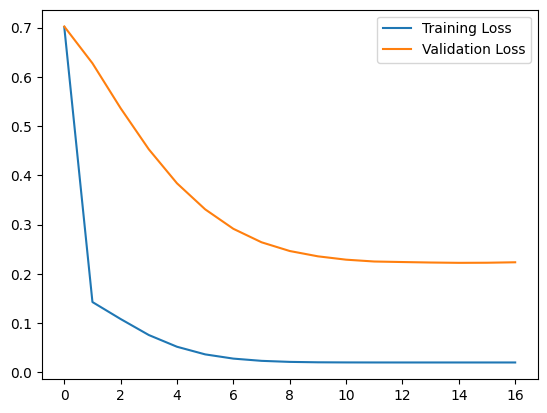

In [613]:
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


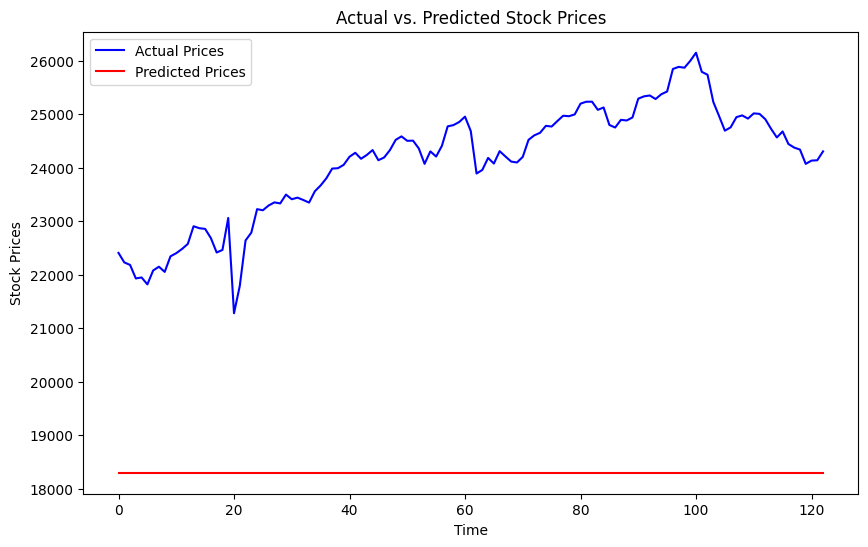

In [614]:
import matplotlib.pyplot as plt
import numpy as np

# Predict stock prices on the test set
predictions = model.predict(X_test)

# Create a placeholder array with the same shape as the original scaled data
# This is needed because `MinMaxScaler` works on the entire dataset structure
predictions_placeholder = np.zeros((predictions.shape[0], scaled_data.shape[1]))
predictions_placeholder[:, 3] = predictions[:, 0]  # Place predictions in the 'Close' column (index 3)

# Inverse transform the predictions to the original scale
predictions_actual = scaler.inverse_transform(predictions_placeholder)[:, 3]  # Extract the 'Close' column

# Prepare the actual test labels (y_test) for inverse transformation
y_test_placeholder = np.zeros((y_test.shape[0], scaled_data.shape[1]))
y_test_placeholder[:, 3] = y_test  # Place actual test values in the 'Close' column (index 3)

# Inverse transform the actual values
y_test_actual = scaler.inverse_transform(y_test_placeholder)[:, 3]  # Extract the 'Close' column

# Plot the actual vs. predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(predictions_actual, label='Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

